In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [149]:
def regression_results(y_true, y_pred):
    
    mse = metrics.mean_squared_error(y_true, y_pred)
    
    print('RMSE: ', round(np.sqrt(mse),4))

In [2]:
# categorias com diferentes escalas de preços
# na maior parte das categorias, o preço médio é mais ou menos parecido
# algumas categorias tem poucas quantidades vendidas; vou usar as 4 maiores (> 1000 quantidades no período)
## mesma coisa para número de pedidos por categoria de produto

In [3]:
# infos importantes:
# nenhum dado nulo ou faltante
# variáveis numéricas: quantidade, preco, pis_cofins, icms, tax_substitution, liquid cost
# variáveis categóricas: category, order_status, process_status, source_channel
# datas: capture_date, process_date

In [4]:
# OBJETIVO: previsão de demanda por categorias de produtos: previsão da média de quantidade diária vendida da categoria de produtos
# previsão do preço médio da categoria a nível diário

In [5]:
# parâmetros que posso usar:
## retirar produtos com poucos pedidos?
## receita bruta
## quantidade pedida acumulada na última semana
## número de dias da última compra da categoria

# Preparação inicial da base de dados

In [2]:
df = pd.read_csv('desafio.csv', sep=',')
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


In [3]:
df = pd.read_csv('desafio.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179149 entries, 0 to 179148
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          179149 non-null  object 
 1   code              179149 non-null  object 
 2   quantity          179149 non-null  int64  
 3   price             179149 non-null  float64
 4   pis_cofins        179149 non-null  float64
 5   icms              179149 non-null  float64
 6   tax_substitution  179149 non-null  float64
 7   category          179149 non-null  object 
 8   liquid_cost       179149 non-null  float64
 9   order_status      179149 non-null  object 
 10  capture_date      179149 non-null  object 
 11  process_date      179149 non-null  object 
 12  process_status    179149 non-null  object 
 13  source_channel    179149 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 19.1+ MB


In [4]:
df = pd.read_csv('desafio.csv', sep=',')
df.describe()

,quantity,price,pis_cofins,icms,tax_substitution,liquid_cost
count,179149.000000,179149.000000,179149.000000,179149.000000,179149.000000,179149.000000
mean,1.055278,234.638585,19.525329,25.095547,17.872443,136.034906
std,0.597942,186.638919,17.402820,32.333226,28.125661,83.603243
min,1.000000,1.030000,0.000000,0.000000,0.000000,4.114100
25%,1.000000,149.910000,10.640300,0.000000,0.000000,78.862100
50%,1.000000,194.400000,17.519500,21.492000,0.000000,117.082000
75%,1.000000,309.360000,28.157000,38.880000,30.403000,205.899700
max,100.000000,19993.000000,1849.352500,3598.740000,280.834200,896.681400


In [5]:
df['process_date'] = df['process_date'].apply(lambda x: np.nan if x == '0000-00-00' else x)
df['capture_date'] = pd.to_datetime(df['capture_date'], format="%Y/%m/%d")
df['process_date'] = pd.to_datetime(df['process_date'], format="%Y/%m/%d")

array([[<AxesSubplot:title={'center':'388128822cef4b4f102ae881e040a64b'}>,
        <AxesSubplot:title={'center':'4ece547755cba9e7fc14125bc895f31b'}>,
        <AxesSubplot:title={'center':'568696c0b6828f77884ea8628fcc6200'}>],
       [<AxesSubplot:title={'center':'61ad270def6d4b2403f4536f39cff29a'}>,
        <AxesSubplot:title={'center':'90cc5bdd050bcd7cf0d50d079d0fda66'}>,
        <AxesSubplot:title={'center':'98f679396a60f117b171ddedfcc3e5ed'}>],
       [<AxesSubplot:title={'center':'9a97178a18aa6333aabdfb21de182b99'}>,
        <AxesSubplot:title={'center':'9cfa7aefcc61936b70aaec6729329eda'}>,
        <AxesSubplot:title={'center':'d7ecf0071e88c21e993da125d2229a51'}>],
       [<AxesSubplot:title={'center':'dda10a917a9ea3120e5d299af5105290'}>,
        <AxesSubplot:title={'center':'f79dccaf0b890eced0724d8563948c4f'}>,
        <AxesSubplot:>]], dtype=object)

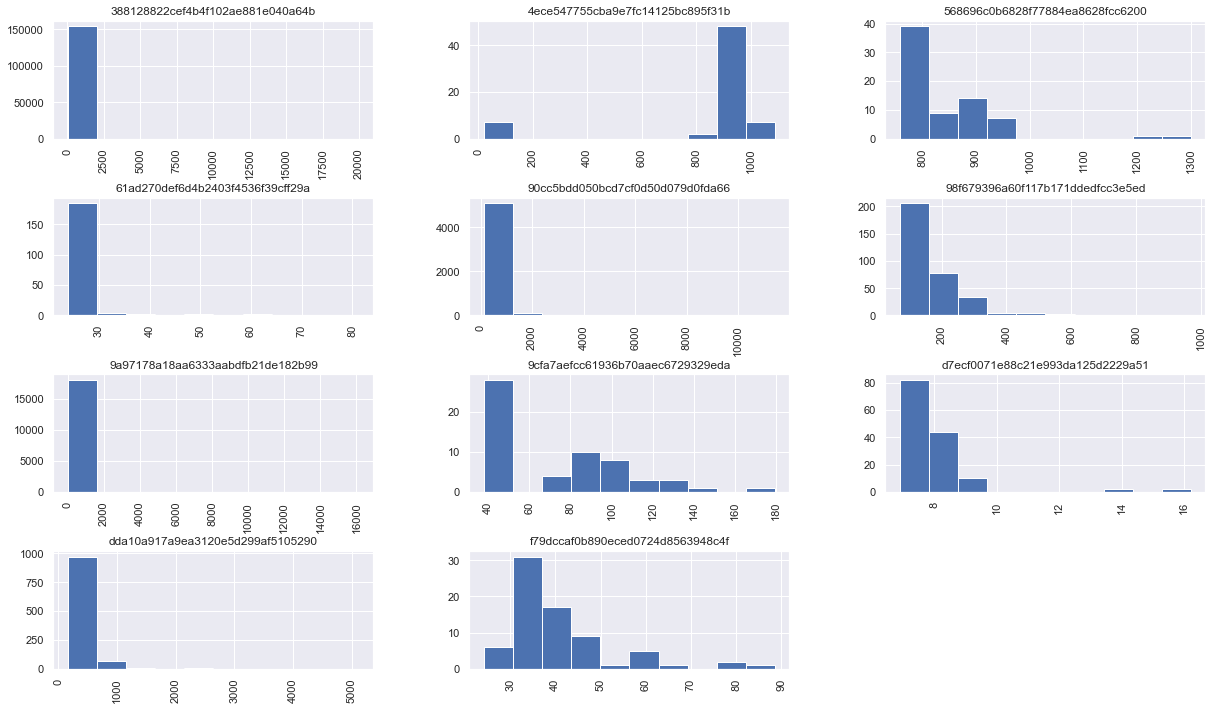

In [6]:
sns.set(rc={'figure.figsize': (20, 12)})
df['price'].hist(by=df['category'])

In [7]:
# categorias com diferentes escalas de preços
# na maior parte das categorias, o preço médio é mais ou menos parecido
# algumas categorias tem poucas quantidades vendidas; vou usar as 4 maiores (> 1000 quantidades no período)
## mesma coisa para número de pedidos por categoria de produto

In [8]:
df.groupby('category').agg({'quantity': 'sum'}).sort_values('quantity', ascending=False)

,quantity
category,
388128822cef4b4f102ae881e040a64b,161141
9a97178a18aa6333aabdfb21de182b99,19685
90cc5bdd050bcd7cf0d50d079d0fda66,5791
dda10a917a9ea3120e5d299af5105290,1440
98f679396a60f117b171ddedfcc3e5ed,378
61ad270def6d4b2403f4536f39cff29a,203
d7ecf0071e88c21e993da125d2229a51,140
f79dccaf0b890eced0724d8563948c4f,75
568696c0b6828f77884ea8628fcc6200,71


In [9]:
df.groupby('category').agg({'order_id': 'count'}).sort_values('order_id', ascending=False)

,order_id
category,
388128822cef4b4f102ae881e040a64b,153943
9a97178a18aa6333aabdfb21de182b99,18009
90cc5bdd050bcd7cf0d50d079d0fda66,5208
dda10a917a9ea3120e5d299af5105290,1053
98f679396a60f117b171ddedfcc3e5ed,330
61ad270def6d4b2403f4536f39cff29a,200
d7ecf0071e88c21e993da125d2229a51,140
f79dccaf0b890eced0724d8563948c4f,73
568696c0b6828f77884ea8628fcc6200,71


In [10]:
df_valido = df[(
                (df.order_status != 'cancelado boleto não pago') & 
                (df.order_status != 'cancelado') &
                (df.order_status != 'solicitação de cancelamento') &
                (df.order_status != 'cancelado dados divergentes') &
                (df.order_status != 'fraude confirmada') &
                (df.order_status != 'cancelado fraude confirmada') &
                (df.order_status != 'cancelado não aprovado') &
                (df.order_status != 'suspeita de fraude')
                )]
df_valido.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500
5,a8ad36828898fa3f6efeb5bd19c076f2,e6762ba2ffbca07ab6cee7551caeaad5,1,1089.10,100.7418,185.1470,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,9d3e0fcbc1f16d80a76026e8f1c26002


In [11]:
max_cat = df_valido[(df_valido['category'] == '388128822cef4b4f102ae881e040a64b')]
max_cat.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
356,2b382c9769a8f6a564089928642c12c6,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-09,processado,b76eb9b8fc0f17098812da9117d3e500
357,82134261102be216e336e8e36ea46cdb,723f73c85e91fc31d147dfade389d4f9,1,464.40,42.9570,54.4881,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,b76eb9b8fc0f17098812da9117d3e500
358,5a5b7a1c31f1fd87e8b74656f2822542,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-10,processado,b76eb9b8fc0f17098812da9117d3e500
359,02f1253d9a6bd3792e7ac5ff187ff2ef,723f73c85e91fc31d147dfade389d4f9,1,449.90,41.6158,52.7868,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,98defd6ee70dfb1dea416cecdf391f58
360,ca7ae41d48db38b1b2c57f8567bfdfc1,723f73c85e91fc31d147dfade389d4f9,1,449.88,41.6139,0.0000,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,7261d300057219056592010c7bdaf5ee


In [12]:
# variáveis numéricas: quantidade, preco, pis_cofins, icms, tax_substitution, liquid cost
ts_df = max_cat.groupby('capture_date').agg(mean_qtt=('price', 'mean'), mean_price=('quantity', 'mean'), 
                                       mean_pis=('pis_cofins', 'mean'), mean_icms=('icms', 'mean'),
                                       mean_tax=('tax_substitution', 'mean'), mean_lcost=('liquid_cost', 'mean'))
                                       
ts_df.shape

(366, 6)

In [13]:
ts_df.head()

,mean_qtt,mean_price,mean_pis,mean_icms,mean_tax,mean_lcost
capture_date,,,,,,
2016-06-01,270.062275,1.015873,24.980768,29.589665,18.711901,144.393844
2016-06-02,295.690674,1.082902,27.351391,28.630523,24.450794,151.919233
2016-06-03,242.440630,1.015748,22.425762,22.564564,20.713281,138.287498
2016-06-04,253.820508,1.067797,23.478408,21.436694,24.842447,143.317076
2016-06-05,273.093927,1.026178,25.261195,23.015852,26.811114,154.787212


array([[<AxesSubplot:title={'center':'mean_qtt'}>,
        <AxesSubplot:title={'center':'mean_price'}>],
       [<AxesSubplot:title={'center':'mean_pis'}>,
        <AxesSubplot:title={'center':'mean_icms'}>],
       [<AxesSubplot:title={'center':'mean_tax'}>,
        <AxesSubplot:title={'center':'mean_lcost'}>]], dtype=object)

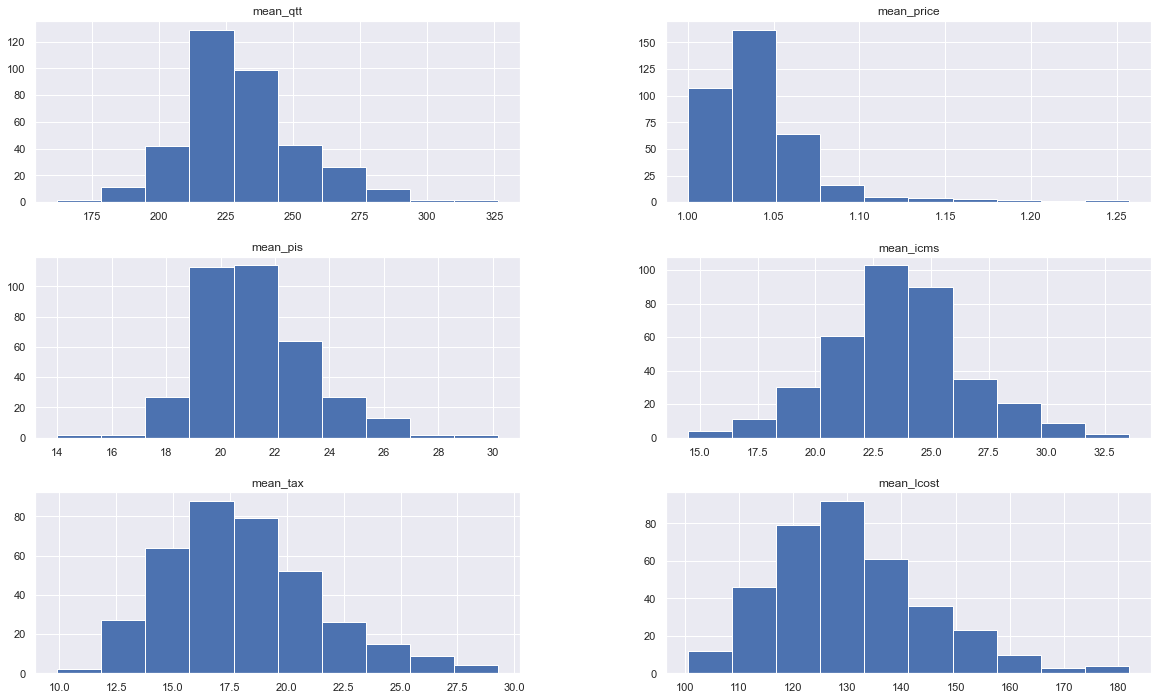

In [14]:
# sns.set(rc={'figure.figsize': (20, 12)})
ts_df.hist()

<AxesSubplot:>

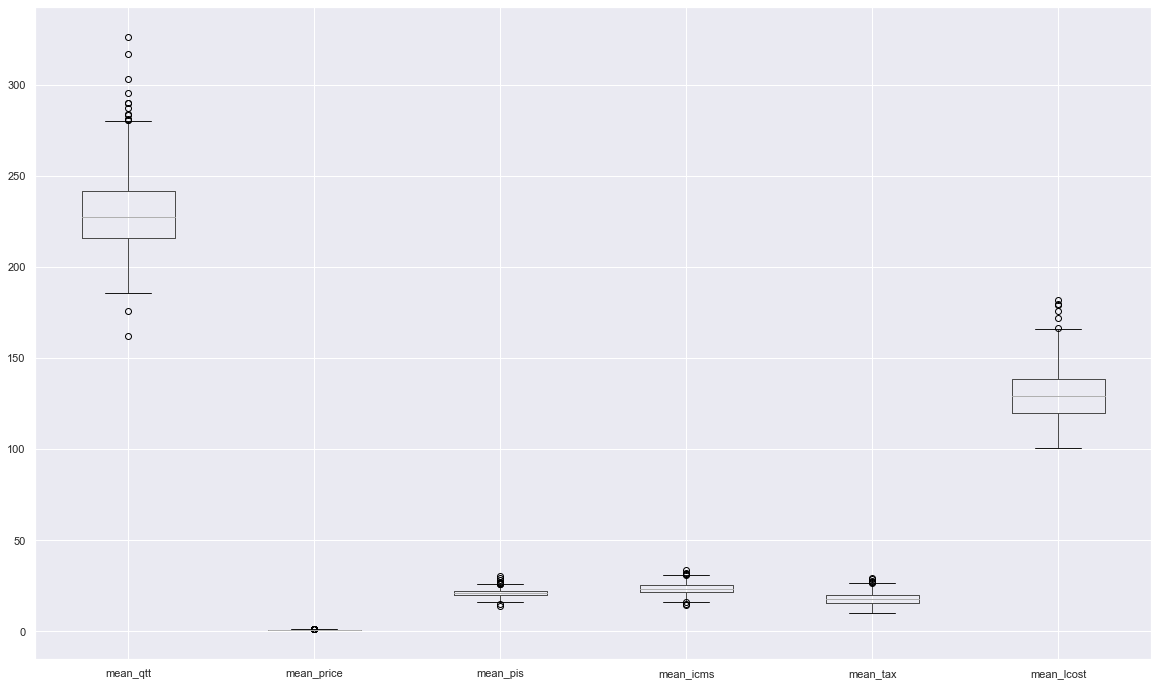

In [15]:
ts_df.boxplot()

array([[<AxesSubplot:xlabel='mean_qtt', ylabel='mean_qtt'>,
        <AxesSubplot:xlabel='mean_price', ylabel='mean_qtt'>,
        <AxesSubplot:xlabel='mean_pis', ylabel='mean_qtt'>,
        <AxesSubplot:xlabel='mean_icms', ylabel='mean_qtt'>,
        <AxesSubplot:xlabel='mean_tax', ylabel='mean_qtt'>,
        <AxesSubplot:xlabel='mean_lcost', ylabel='mean_qtt'>],
       [<AxesSubplot:xlabel='mean_qtt', ylabel='mean_price'>,
        <AxesSubplot:xlabel='mean_price', ylabel='mean_price'>,
        <AxesSubplot:xlabel='mean_pis', ylabel='mean_price'>,
        <AxesSubplot:xlabel='mean_icms', ylabel='mean_price'>,
        <AxesSubplot:xlabel='mean_tax', ylabel='mean_price'>,
        <AxesSubplot:xlabel='mean_lcost', ylabel='mean_price'>],
       [<AxesSubplot:xlabel='mean_qtt', ylabel='mean_pis'>,
        <AxesSubplot:xlabel='mean_price', ylabel='mean_pis'>,
        <AxesSubplot:xlabel='mean_pis', ylabel='mean_pis'>,
        <AxesSubplot:xlabel='mean_icms', ylabel='mean_pis'>,
        <Axes

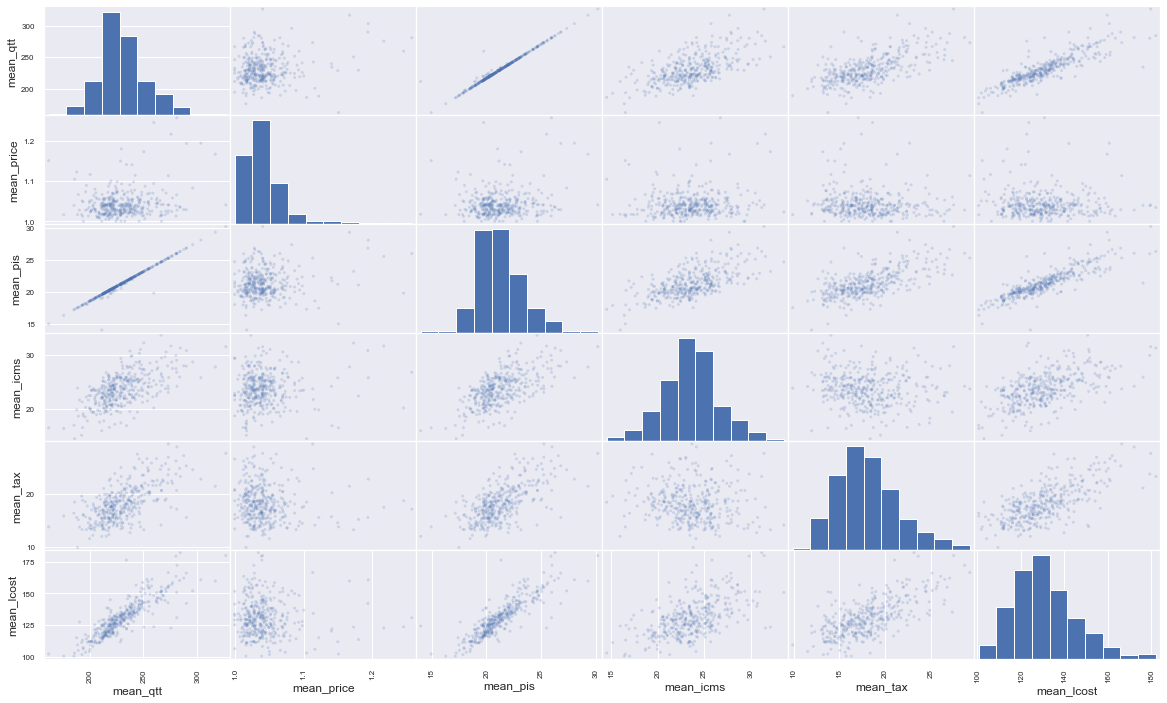

In [16]:
pd.plotting.scatter_matrix(ts_df, alpha=0.2)

In [20]:
# variáveis em escala diferente, precisa fazer feature scaling
# tem outliers, então precisa de tratamento que considera outliers
# portanto, vou usar o robust

# Separação da base de dados

In [17]:
X = ts_df[['mean_price','mean_pis', 'mean_icms', 'mean_tax', 'mean_lcost']]
y = ts_df[['mean_qtt']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(292, 5)
(292, 1)
(74, 5)
(74, 1)


# Análise exploratória dos dados

dúvida: preciso fazer a matriz de correlação com o y?

<AxesSubplot:>

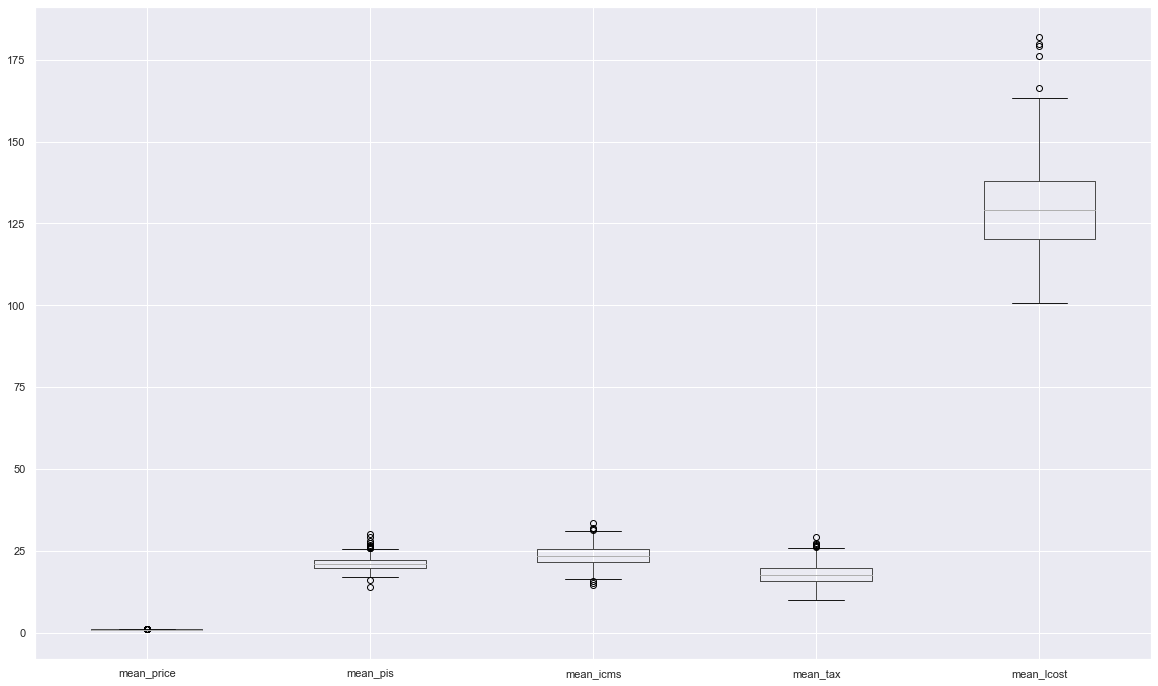

In [19]:
X_train.boxplot()

array([[<AxesSubplot:title={'center':'mean_price'}>,
        <AxesSubplot:title={'center':'mean_pis'}>],
       [<AxesSubplot:title={'center':'mean_icms'}>,
        <AxesSubplot:title={'center':'mean_tax'}>],
       [<AxesSubplot:title={'center':'mean_lcost'}>, <AxesSubplot:>]],
      dtype=object)

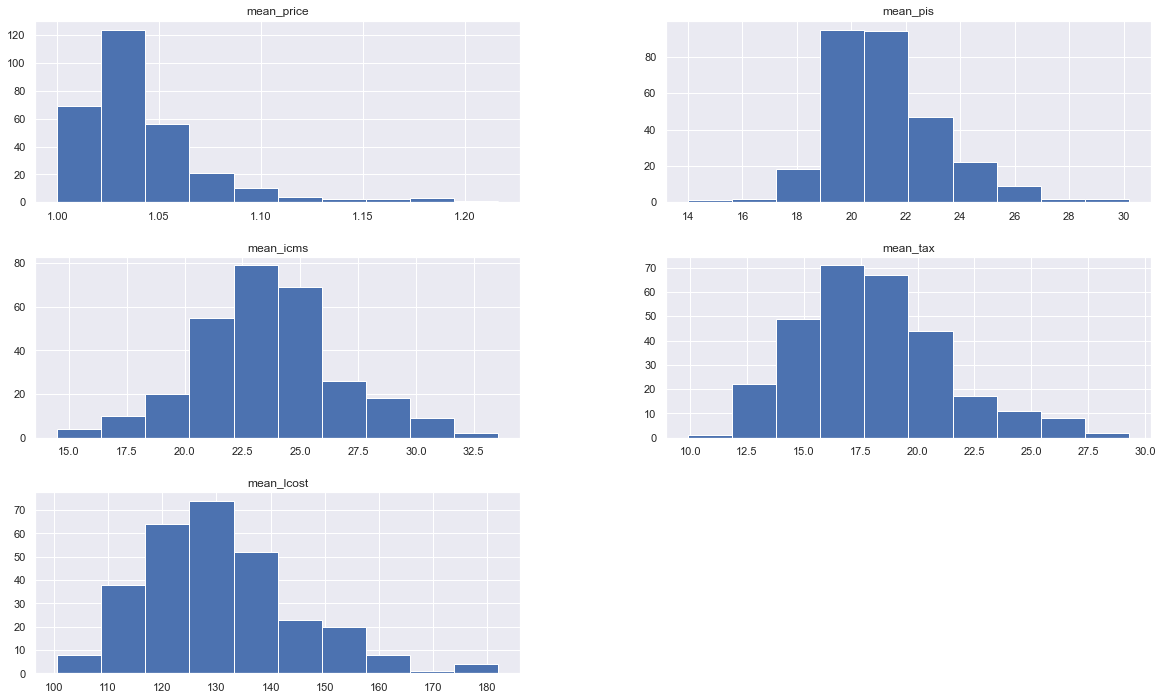

In [20]:
X_train.hist()

# Scaler: conjunto de treino

In [21]:
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_train = pd.DataFrame(X_train)

In [22]:
X_train.head()

,0,1,2,3,4
0,-0.128861,-0.858299,-0.420019,-0.570033,-0.416999
1,-0.847340,-1.067154,-0.506525,-0.800618,-0.729533
2,-0.082834,2.229648,1.993827,1.314110,2.999092
3,-0.924670,0.315052,1.134176,-0.639686,0.490846
4,-0.190576,0.449327,-0.654457,0.851668,0.120279


<AxesSubplot:>

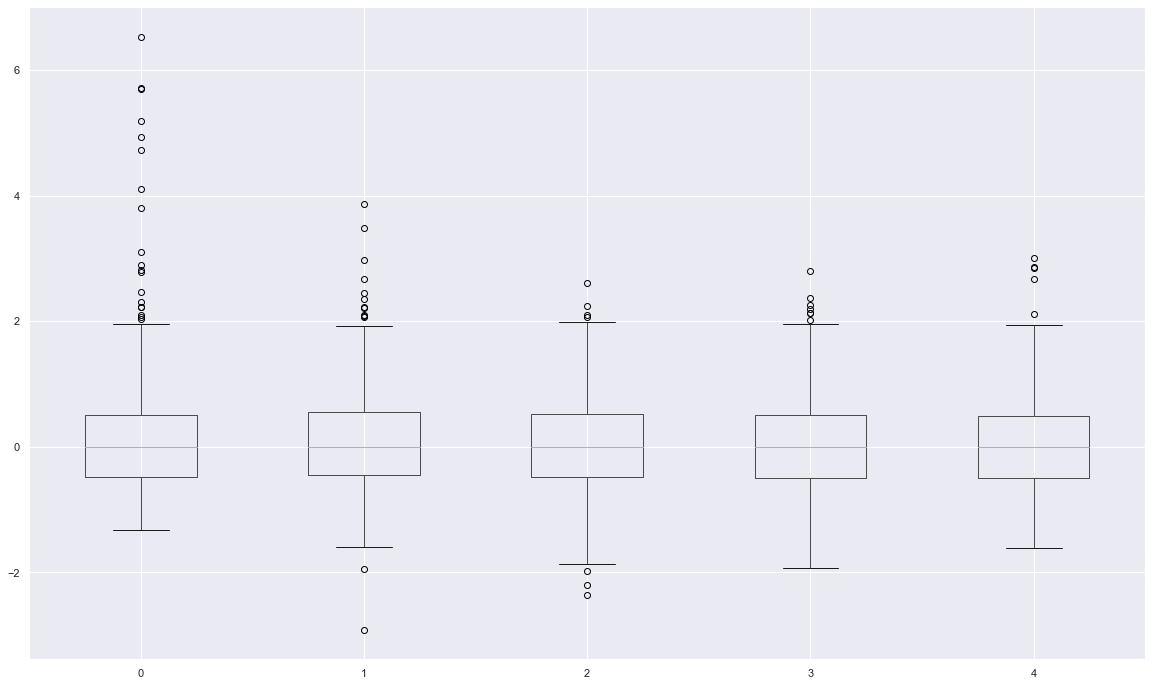

In [23]:
X_train.boxplot()

# Scaler: conjunto de teste

In [24]:
# usa o transformer de teste mesmo né?
transformer = RobustScaler().fit(X_test)
X_test = transformer.transform(X_test)
X_test = pd.DataFrame(X_test)

# Multicolinearidade

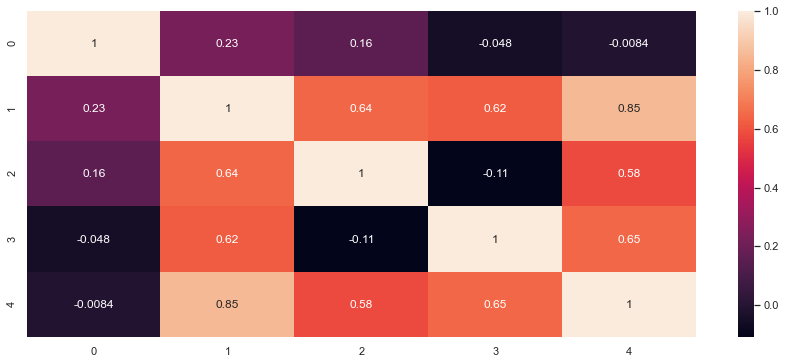

In [25]:
plt.figure(figsize=(15, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='rocket')
plt.show()

In [26]:
# pis e lcost -> tem corr de 0.85 (correlação alta) -> vou tirar do modelo
# vif > 10 -> fudeu, e agora?
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

[1.3624344905981765,
 12.533472975898906,
 10.612855847069353,
 11.357455825864543,
 7.003193169899121]

In [114]:
# MODELO SEM PIS
ts_df = max_cat.groupby('capture_date').agg(mean_qtt=('price', 'mean'), mean_price=('quantity', 'mean'), 
                                       mean_icms=('icms', 'mean'),
                                       mean_tax=('tax_substitution', 'mean'), mean_lcost=('liquid_cost', 'mean'))
                                       
ts_df.shape

(366, 5)

In [144]:
X = ts_df[['mean_price', 'mean_icms', 'mean_tax', 'mean_lcost']]
y = ts_df[['mean_qtt']]

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(292, 4)
(292, 1)
(74, 4)
(74, 1)


In [146]:
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_train = pd.DataFrame(X_train)

<AxesSubplot:>

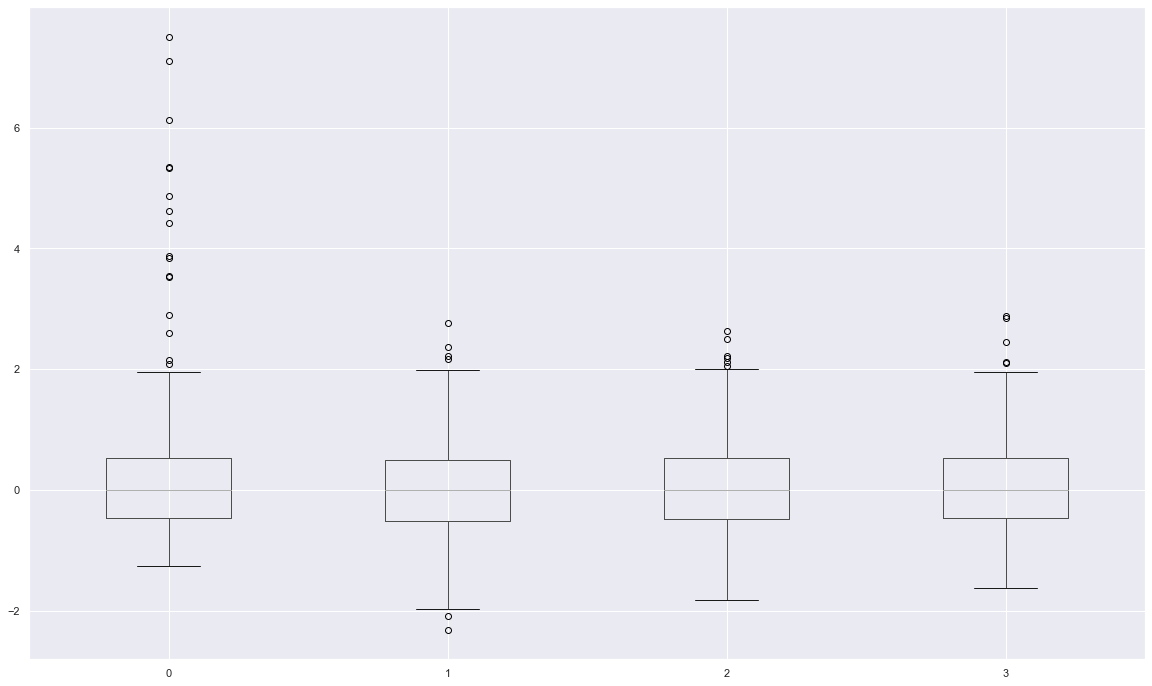

In [147]:
X_train.boxplot()

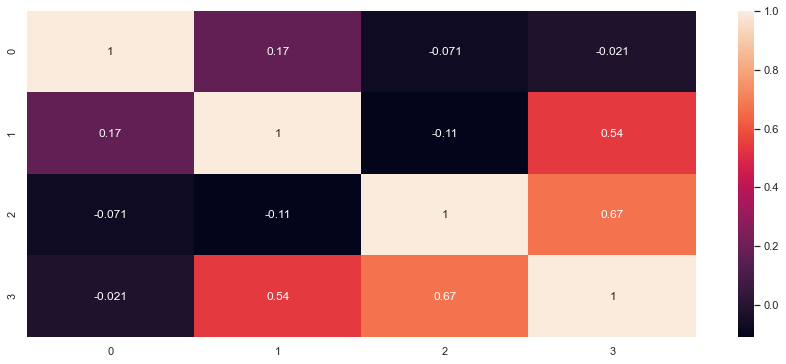

In [31]:
plt.figure(figsize=(15, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='rocket')
plt.show()

In [32]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

[1.0611533463531533, 3.6375627549942586, 4.559526852279136, 6.450302546221685]

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3', ylabel='3'>]], dtype=object)

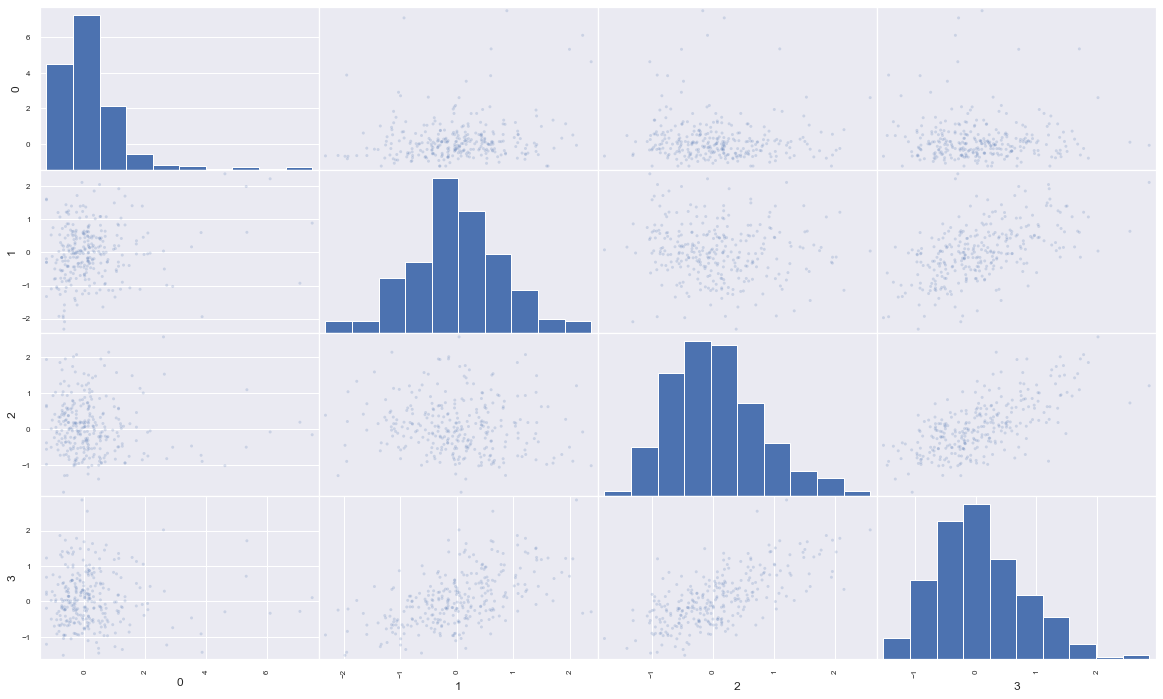

In [34]:
pd.plotting.scatter_matrix(X_train, alpha=0.2)

# Modelos regressivos

Em todos, serão aplicados os modelos, validação cruzada e grid search

# Regressão linear múltipla

In [81]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

In [82]:
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores

array([ -46.51011213,  -62.27056172,  -59.50921552,  -42.31751335,
        -81.43221374, -124.44470736,  -49.04623796,  -84.27359163,
        -40.82758356,  -29.06584238])

In [83]:
lr_rmse = np.sqrt(-scores)
mean_lr_rmse = np.mean(lr_rmse)
std_lr_rmse = np.std(lr_rmse)
mean_lr_rmse, std_lr_rmse
# calcular o intervalo de predição

(7.7074161838800865, 1.6017158628913206)

In [84]:
y_pred_lr = lr.predict(X_test)
regression_results(y_test, y_pred_lr)

MSE:  1368161.6201
RMSE:  1169.6844


# Árvore de decisão

In [99]:
regr_tree = tree.DecisionTreeRegressor()
regr_tree = regr_tree.fit(X_train, y_train)

In [100]:
scores = cross_val_score(regr_tree, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores

array([-216.83419873, -138.07090725, -215.25090004,  -81.60446448,
       -177.08082308, -145.85412163, -105.73824523, -181.6169439 ,
       -184.3820424 , -130.59756525])

In [101]:
# calcular o intervalo de predição
regr_tree_rmse = np.sqrt(-scores)
mean_regr_tree_rmse = np.mean(regr_tree_rmse)
std_regr_tree_rmse = np.std(regr_tree_rmse)
mean_regr_tree_rmse, std_regr_tree_rmse

(12.433088662282476, 1.7667279119117176)

In [102]:
y_pred_tree = regr_tree.predict(X_test)
regression_results(y_test, y_pred_tree)

MSE:  9629.3155
RMSE:  98.1291


In [103]:
y_pred_tree

array([326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46477157,
       326.46477157, 326.46477157, 326.46477157, 326.46

# XGBoost

In [119]:
regr_xgb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
regr_xgb = regr_xgb.fit(X_train, y_train)

In [120]:
scores = cross_val_score(regr_xgb, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores

array([-6847.72477844, -6848.21588096, -6407.52179153, -7388.87549117,
       -5483.00161117, -8824.24837348, -6855.06134608, -7586.62815126,
       -6997.26719185, -5808.54804603])

In [121]:
regr_xgb_rmse = np.sqrt(-scores)
mean_regr_xgb_rmse = np.mean(regr_xgb_rmse)
std_regr_xgb_rmse = np.std(regr_xgb_rmse)
mean_regr_xgb_rmse, std_regr_xgb_rmse

(82.92553084457973, 5.29769764524581)

In [122]:
y_pred_xgb = regr_xgb.predict(X_test)
regression_results(y_test, y_pred_xgb)

MSE:  5434.3547
RMSE:  73.7181


In [123]:
regr_xgb.feature_importances_

array([0.        , 0.        , 0.3041205 , 0.69587946], dtype=float32)

# Avaliação de modelos

# Regressão linear múltipla

In [148]:
print('média de RMSE: ' + str(mean_lr_rmse) + ' | desvio padrão: ' + str(std_lr_rmse))
regression_results(y_test, y_pred_lr)

média de RMSE: 7.7074161838800865 | desvio padrão: 1.6017158628913206
MSE:  1364913.971
RMSE:  1168.2953


<AxesSubplot:xlabel='capture_date'>

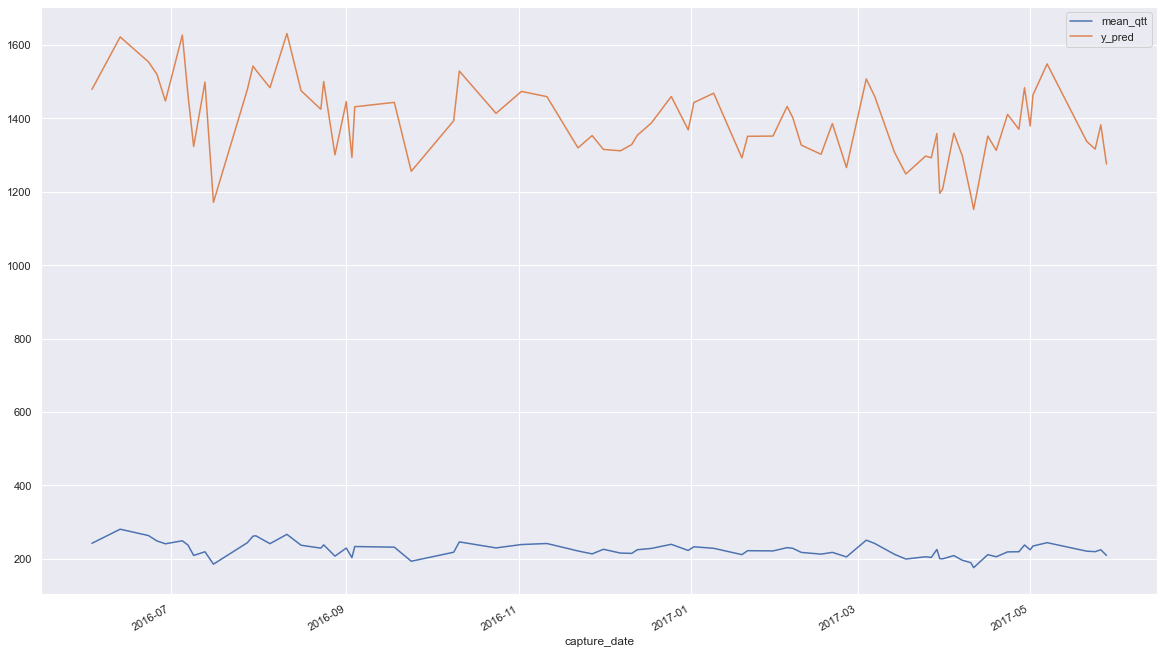

In [93]:
df_lr = pd.DataFrame(y_test)
df_lr['y_pred'] = y_pred_lr
df_lr.plot()

# Árvore de decisão tradicional

In [141]:
print('média de RMSE: ' + str(mean_regr_tree_rmse) + ' | desvio padrão: ' + str(std_regr_tree_rmse))
regression_results(y_test, y_pred_tree)

média de RMSE: 12.433088662282476 | desvio padrão: 1.7667279119117176
MSE:  9527.0674
RMSE:  97.6067


<AxesSubplot:xlabel='capture_date'>

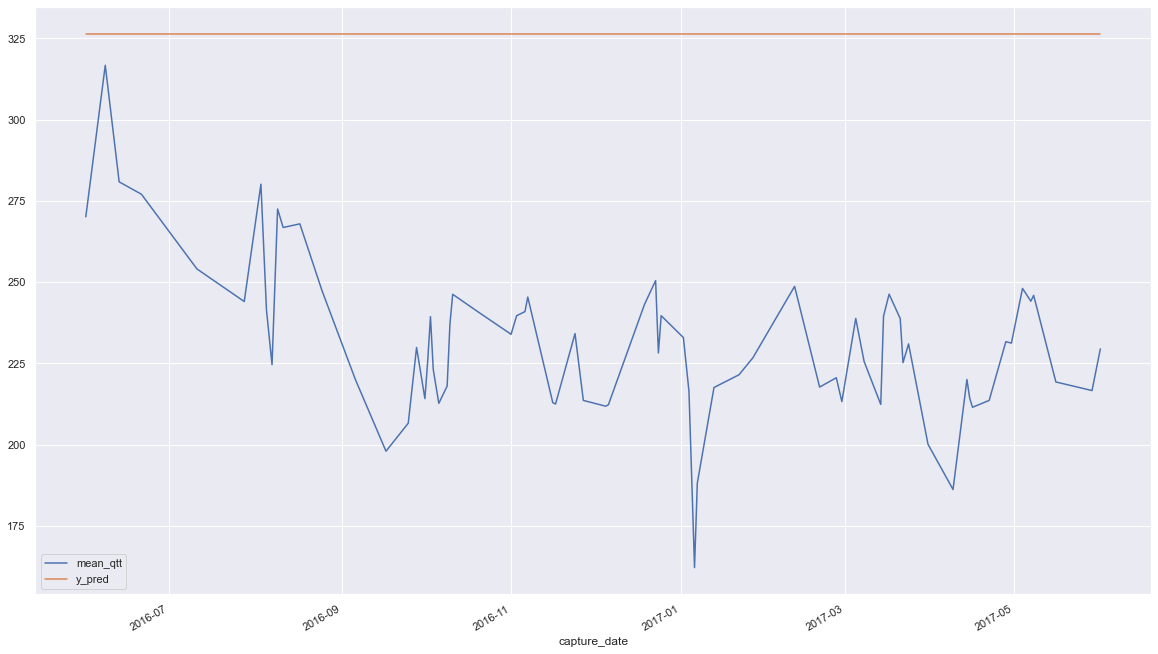

In [142]:
df_tree = pd.DataFrame(y_test)
df_tree['y_pred'] = y_pred_tree
df_tree.plot()

[Text(636.4710242983098, 634.2, 'X[3] <= 0.264\nmse = 501.197\nsamples = 292\nvalue = 230.51'),
 Text(325.08729066673624, 597.96, 'X[3] <= -0.643\nmse = 202.163\nsamples = 188\nvalue = 218.917'),
 Text(50.07095158597663, 561.72, 'X[3] <= -1.114\nmse = 146.275\nsamples = 50\nvalue = 205.056'),
 Text(16.767946577629385, 525.48, 'X[1] <= -1.876\nmse = 126.335\nsamples = 11\nvalue = 189.75'),
 Text(7.452420701168615, 489.24, 'X[1] <= -1.953\nmse = 48.741\nsamples = 2\nvalue = 169.099'),
 Text(3.7262103505843074, 453.0, 'mse = 0.0\nsamples = 1\nvalue = 176.081'),
 Text(11.178631051752923, 453.0, 'mse = -0.0\nsamples = 1\nvalue = 162.118'),
 Text(26.083472454090153, 489.24, 'X[1] <= -1.298\nmse = 27.752\nsamples = 9\nvalue = 194.339'),
 Text(18.631051752921536, 453.0, 'X[1] <= -1.585\nmse = 4.077\nsamples = 2\nvalue = 187.559'),
 Text(14.90484140233723, 416.76000000000005, 'mse = 0.0\nsamples = 1\nvalue = 185.539'),
 Text(22.357262103505846, 416.76000000000005, 'mse = 0.0\nsamples = 1\nvalue

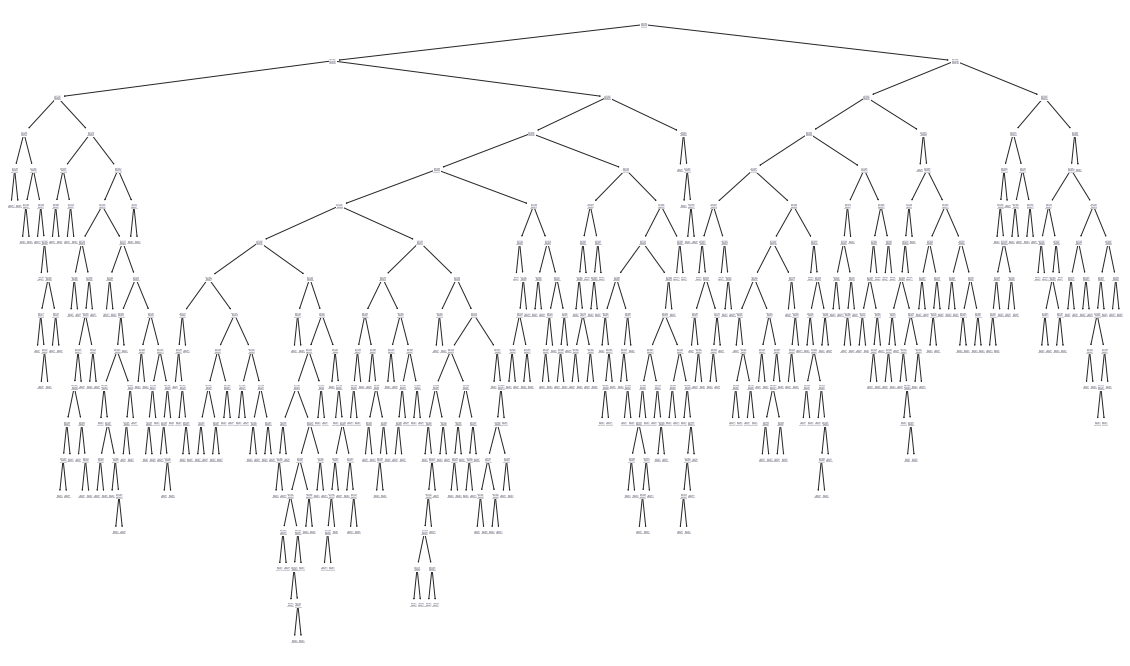

In [129]:
tree.plot_tree(regr_tree)

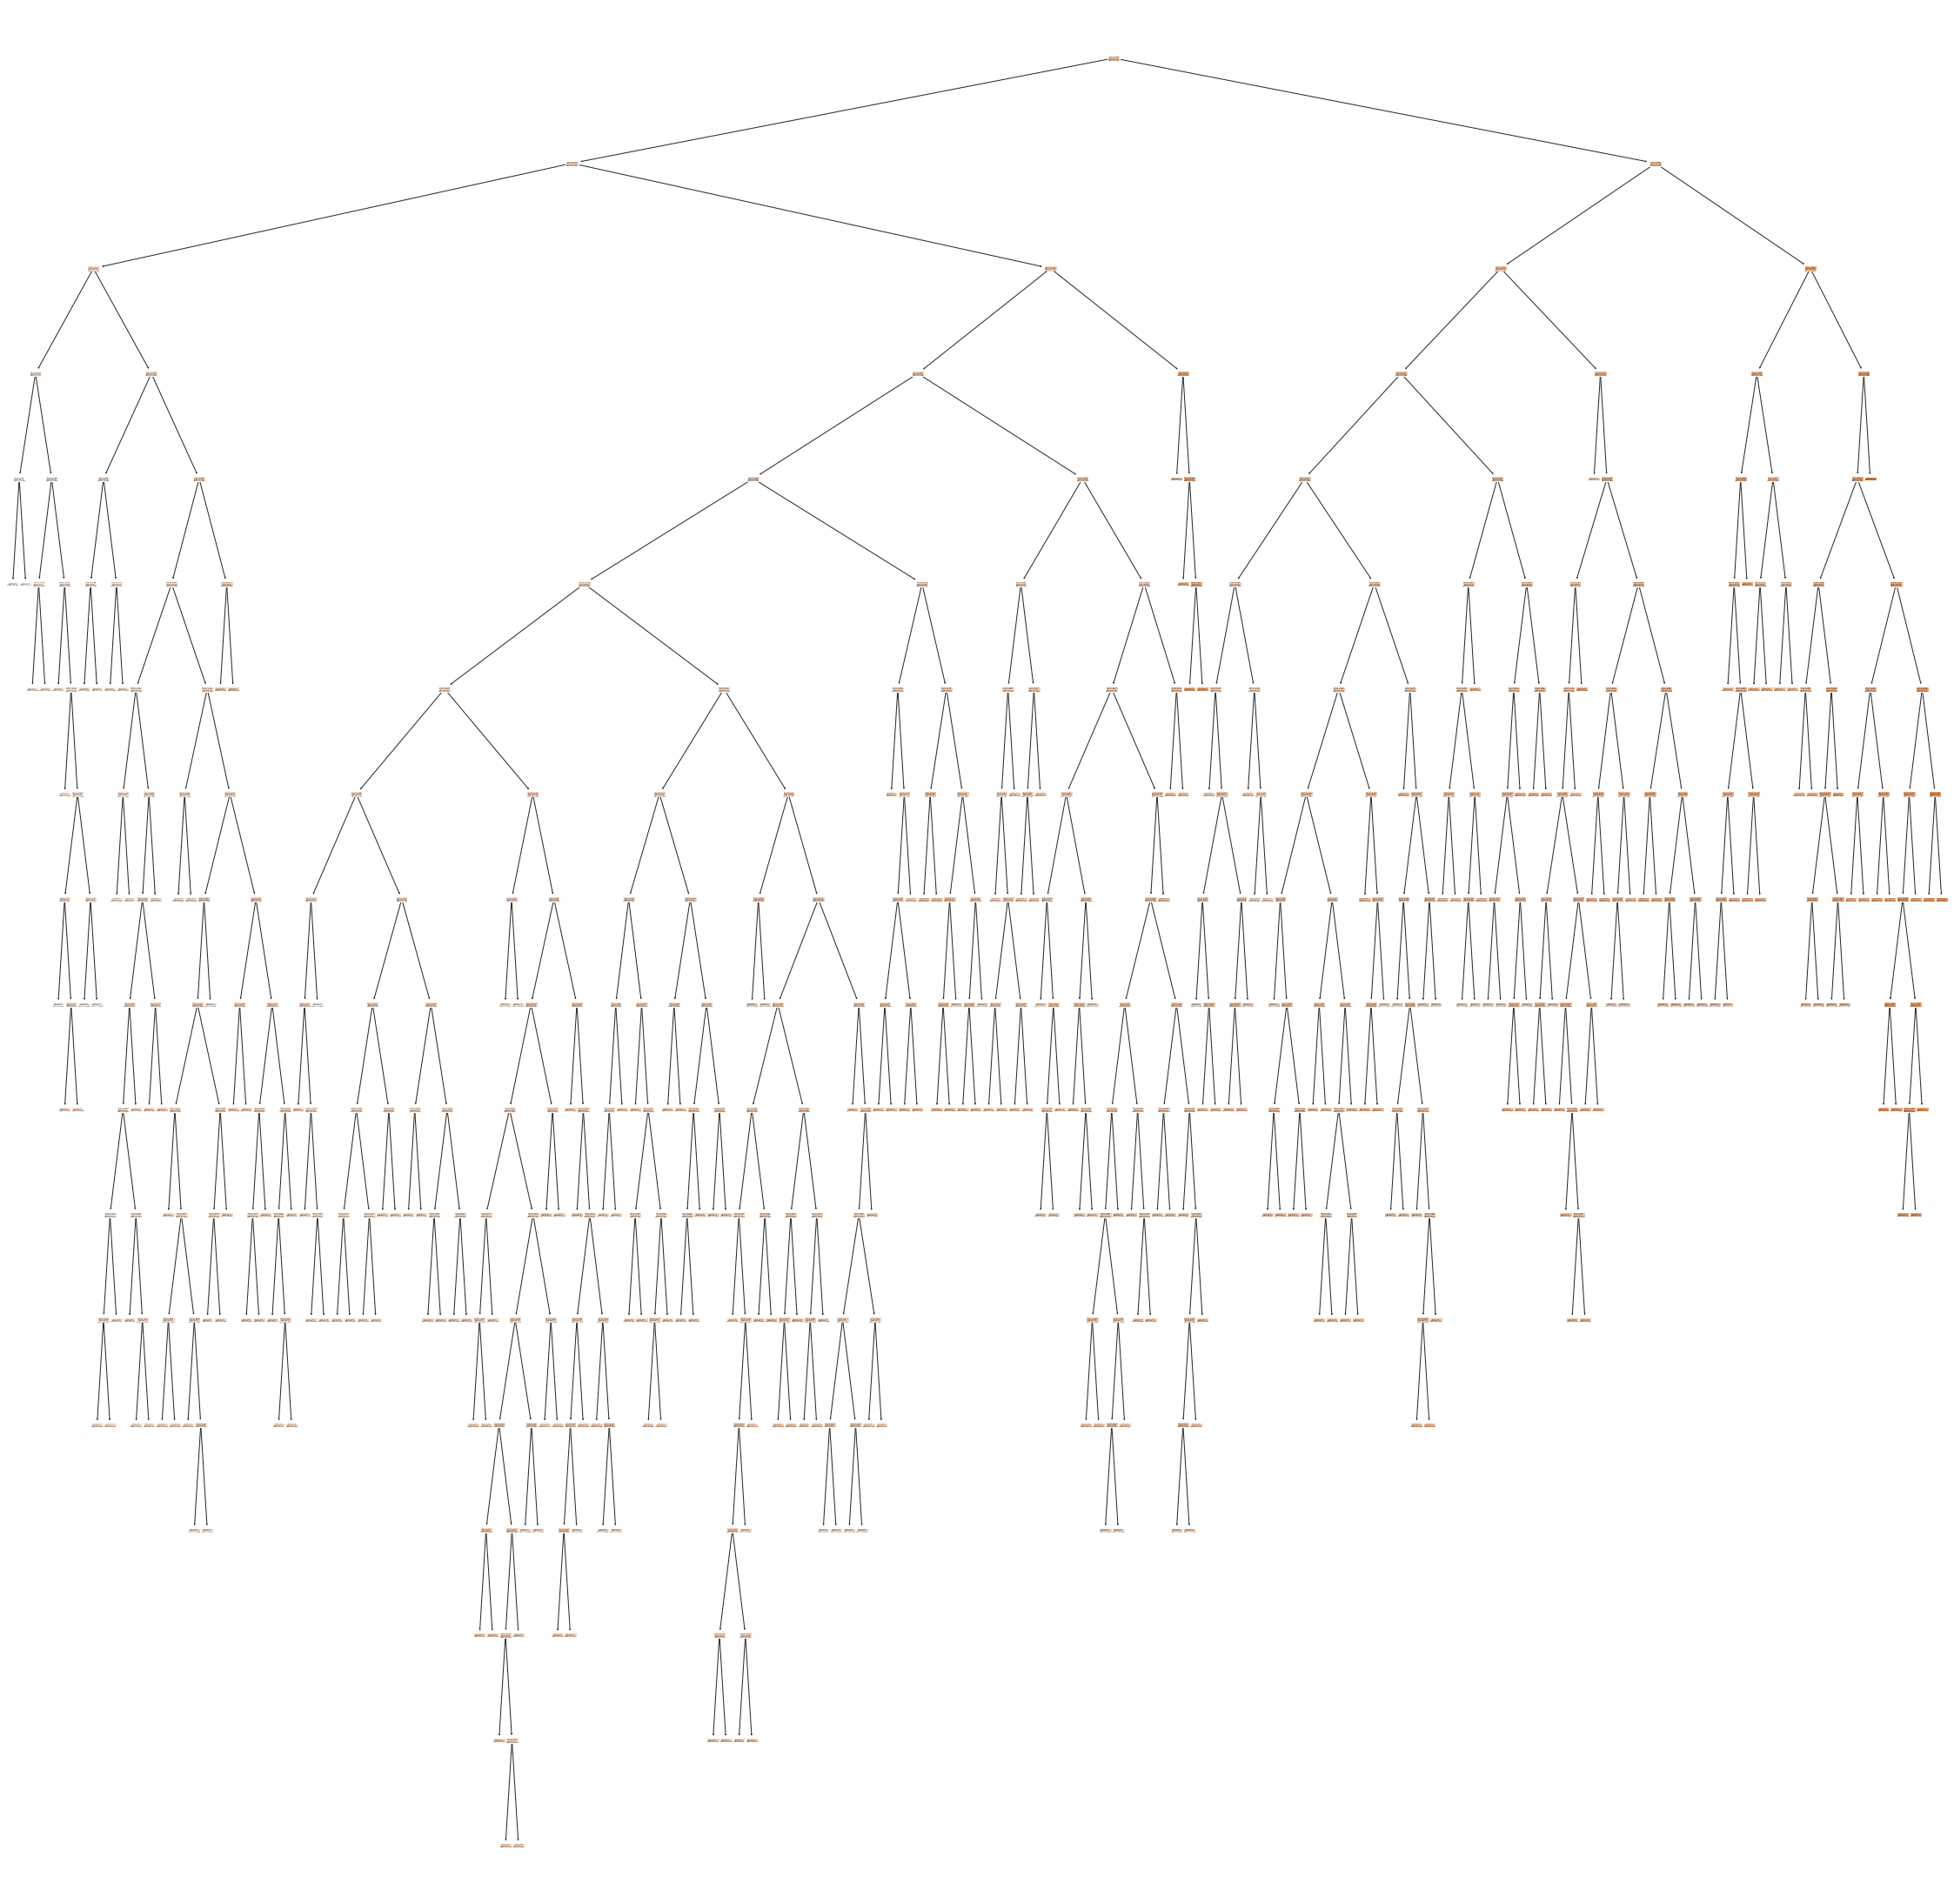

In [151]:
fig = plt.figure(figsize=(40,40))
_ = tree.plot_tree(regr_tree,
                   filled=True)

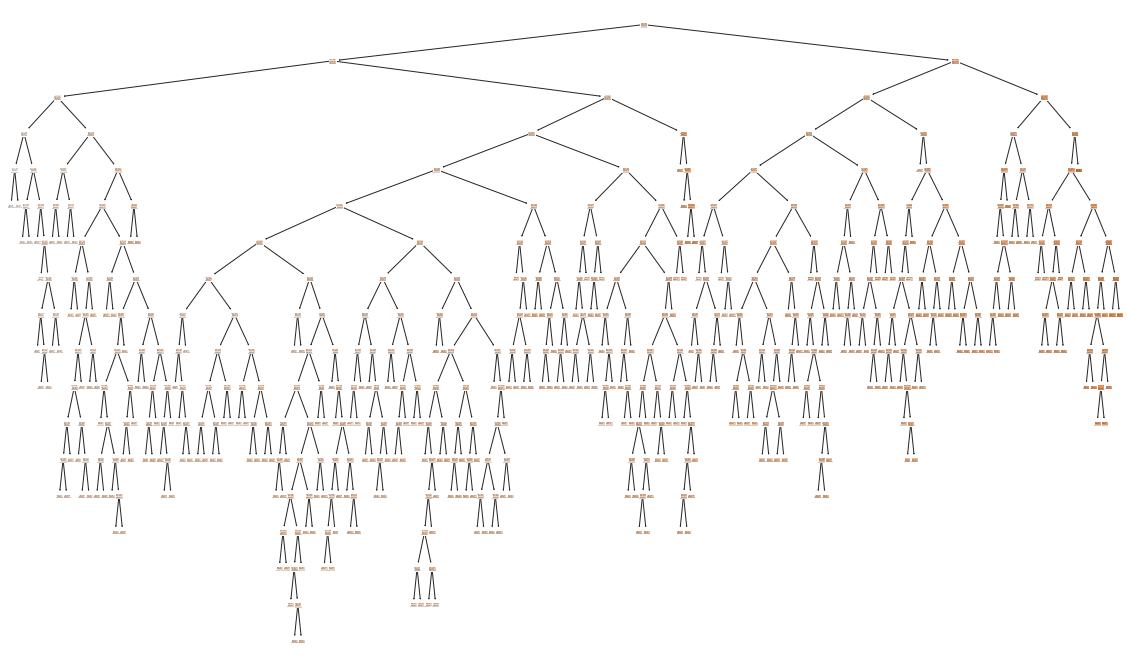

In [152]:
fig2 = plt.figure()
_ = tree.plot_tree(regr_tree,
                   filled=True)

In [154]:
fig.savefig("decistion_tree2.png")

In [153]:
fig2.savefig("decistion_tree.png")

# Árvore de decisão com gradient boosting

In [140]:
print('média de RMSE: ' + str(mean_regr_xgb_rmse) + ' | desvio padrão: ' + str(std_regr_xgb_rmse))
regression_results(y_test, y_pred_xgb)

média de RMSE: 82.92553084457973 | desvio padrão: 5.29769764524581
MSE:  5591.4574
RMSE:  74.776


<AxesSubplot:xlabel='capture_date'>

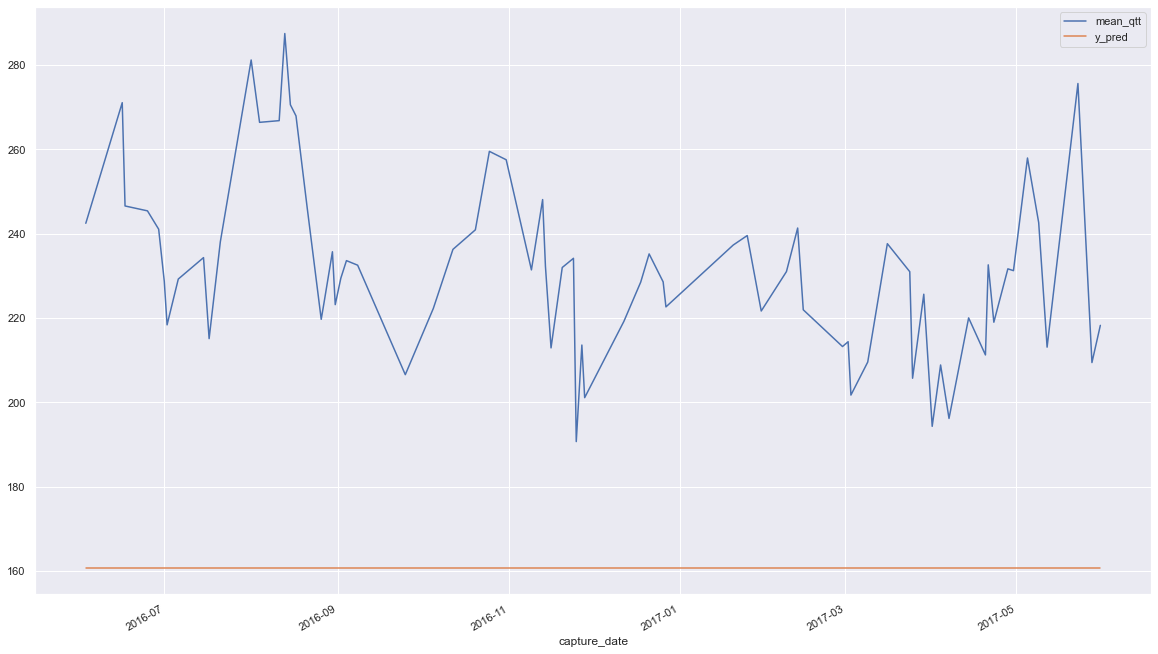

In [131]:
df_xgb = pd.DataFrame(y_test)
df_xgb['y_pred'] = y_pred_xgb
df_xgb.plot()